In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from sklearn.externals import joblib
from scipy import stats
from scipy.optimize import minimize

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

/Users/yang/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [6]:
lifetime = 86400*365 # 1 year! 
# fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-000-3-'
# data_dir = '/Users/yang/Desktop/IceCube/RealTime/i3_processed/'
data_dir = '/Users/yang/Desktop/h5_files/burn_sample_signals/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

In [4]:
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust_2.txt')

def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]

    val = a * np.exp(-b/(dist/2000)**(4.2)) # 2 pulse robust

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
#     val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
#     val[dist > 2210] = 0.8
    return val

# read files

In [13]:
def check_veto(name):
    with tables.open_file(data_dir+name,'r') as f: # 8 years
        CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
        CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
        CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
        CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
        CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
        CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1

        ineff_data_burn = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

        chi2_red_data_burn = f.root.Collection.cols.chi2_red[:]
        chi2_red_new_data_burn = f.root.Collection.cols.chi2_red_new[:]
        PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:]
        stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)

        zenith_data_burn = f.root.SplineMPE.cols.zenith[:]
        truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]
        len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:]
        cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:]
        NPE_data_burn = f.root.QTot.cols.value[:]
        Qtot_data_burn = f.root.Balloon.cols.InIceTotalCharge[:]
        N_dom_data_burn = f.root.Balloon.cols.N_Doms[:]
        balloon_data_burn = f.root.Balloon.cols.InIceBalloonParameter[:]

        closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:]
#         d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:]
        d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:]
#         Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:]
        delta_t_HLC = f.root.IT_veto_vector_delta_t_HLC.cols.item[:]
        delta_t_SLC = f.root.IT_veto_vector_delta_t_SLC.cols.item[:]

        IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:]
        Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:]
        Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:]

        passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # 1 if passed 
        vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) 
        print(Npulse_in_window_data_burn)
        print(delta_t_HLC)
        print(delta_t_SLC)
        """ check pulses """
        plt.figure(figsize=(7,4))
        plt.hist(delta_t_HLC,bins=np.linspace(-1000,2000,100),histtype='step',label='HLC')
        plt.hist(delta_t_SLC,bins=np.linspace(-1000,2000,100),histtype='step',label='SLC')
        plt.xlabel('pulse time - closest approach time [ns]')
        plt.ylabel('N IT hits')
        plt.title('IT pulses inside veto window')
        plt.axvline(-700,color='green')
        plt.axvline(1700,color='blue')
        plt.legend(loc='upper left')
        plt.show()


In [20]:
def check_veto(name):
    with tables.open_file(data_dir+name,'r') as f: # 8 years
#         CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#         CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#         CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#         CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#         CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#         CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1

#         ineff_data_burn = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

#         chi2_red_data_burn = f.root.Collection.cols.chi2_red[:]
#         chi2_red_new_data_burn = f.root.Collection.cols.chi2_red_new[:]
#         PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:]
#         stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)

#         zenith_data_burn = f.root.SplineMPE.cols.zenith[:]
#         truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]
#         len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:]
#         cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:]
#         NPE_data_burn = f.root.QTot.cols.value[:]
#         Qtot_data_burn = f.root.Balloon.cols.InIceTotalCharge[:]
#         N_dom_data_burn = f.root.Balloon.cols.N_Doms[:]
#         balloon_data_burn = f.root.Balloon.cols.InIceBalloonParameter[:]

#         closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:]
#         d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:]
        d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:]
#         Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:]
#         delta_t_HLC = f.root.IT_veto_vector_delta_t_HLC.cols.item[:]
        delta_t_SLC = f.root.IT_veto_vector_delta_t_SLC.cols.item[:]

        IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:]
        Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:]
        Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:]

        passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) # 1 if passed 
        vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:]).astype(bool) 
        print(Npulse_in_window_data_burn)
        print(delta_t_HLC)
        print(delta_t_SLC)
        """ check pulses """
        plt.figure(figsize=(7,4))
        plt.hist(delta_t_HLC,bins=np.linspace(-1000,2000,100),histtype='step',label='HLC')
        plt.hist(delta_t_SLC,bins=np.linspace(-1000,2000,100),histtype='step',label='SLC')
        plt.xlabel('pulse time - closest approach time [ns]')
        plt.ylabel('N IT hits')
        plt.title('IT pulses inside veto window')
        plt.axvline(-700,color='green')
        plt.axvline(1700,color='blue')
        plt.legend(loc='upper left')
        plt.show()


In [21]:
check_veto('data_signals_8yr_122823_37369191.h5')

NoSuchNodeError: group ``/`` does not have a child named ``IT_veto_vector_delta_t_SLC``

In [17]:
check_veto('test.h5')

OSError: ``/Users/yang/Desktop/h5_files/burn_sample_signals/test.h5`` does not exist

[1.]
[0.]
[-6451.22481282 -1733.14117063  6091.85882937 10149.06773319
  7118.67594964   160.58638923  9089.65813218]


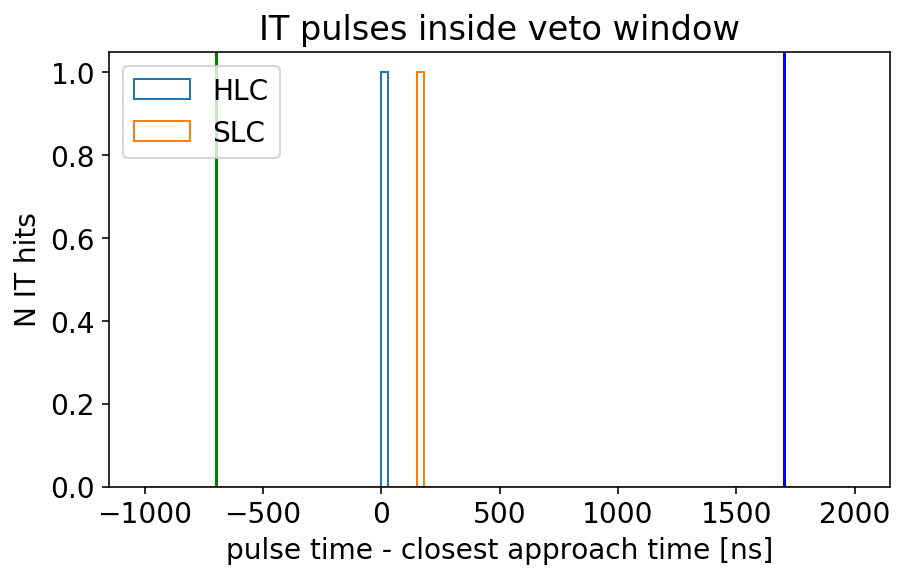

In [60]:
check_veto('test2.h5')

In [ ]:
check_veto('test.h5')